#  Introduction to NoisePy DataStore Class

In [2]:
# Uncomment and run this line if the environment doesn't have noisepy already installed:
# ! pip install noisepy-seis 

__Warning__: NoisePy uses ```obspy``` as a core Python module to manipulate seismic data. Restart the runtime now for proper installation of ```obspy``` on Colab.

This tutorial should be ran after installing the noisepy package. 

In [3]:
from noisepy.seis import  __version__       # noisepy core functions
from noisepy.seis.scedc_s3store import SCEDCS3DataStore, channel_filter # Object to query SCEDC data from on S3
from noisepy.seis.channelcatalog import XMLStationChannelCatalog        # Required stationXML handling object
from datetime import datetime
from datetimerange import DateTimeRange

print(f"Using NoisePy version {__version__}")

S3_STORAGE_OPTIONS = {"s3": {"anon": True}}

/Users/marinedenolle/opt/miniconda3/envs/noisepy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using NoisePy version 0.9.72.dev12


In [4]:
# timeframe for analysis
start = datetime(2022, 1, 2)
end = datetime(2022, 1, 4)
time_range = DateTimeRange(start, end)
print(time_range)

2022-01-02T00:00:00 - 2022-01-04T00:00:00


## DataStore

A noisepy DataStore is a set of classes to accommodate the various types of data store that are necessary because how reseachers store their data, which can be dramatically different w.r.t. formats (mSEED, SAC, SEG-Y), file system (local, S3), and naming conventions. Our noisepy team does not impose a definite data structure, but instead suggest to wrap the data storage structure into a python class. A Data Store class can be the front-end of the real back-end data storage, and return data through read_data function. It allows users to customize based on how they store the data, and leaving the rest of the workflow untouched.

See https://github.com/noisepy/NoisePy/blob/main/src/noisepy/seis/stores.py for more about `DataStore` Class.

### S3 DataStore
Here, we instantiate a `SCEDCS3DataStore` class as `raw_store` as an example of Data Store on the cloud. This variable allows reading data from the real data storage backend during the later processing. The initialization parameters of `SCEDCS3DataStore` are
- S3_DATA: path to the data in the "s3://" format. 
- catalog: path to the station XML available in the "s3://" format.
- channel_filter: channel selection, based on station name and/or channel type.
- time_range: DateTimeRange of data for processing.
- storage_option: optimal storage option to read S3 data. This is where you can put AWS keys/credential if applicable.

See https://github.com/noisepy/NoisePy/blob/main/src/noisepy/seis/scedc_s3store.py for `SCEDCS3DataStore`

We will work with a single day worth of data on SCEDC. The continuous data is organized with a single day and channel per miniseed (https://scedc.caltech.edu/data/cloud.html). For this example, you can choose any year since 2002. We will just cross correlate a single day.

In [5]:
# SCEDC S3 bucket common URL characters for that day.
S3_DATA = "s3://scedc-pds/continuous_waveforms/"

# S3 storage of stationXML
S3_STATION_XML = "s3://scedc-pds/FDSNstationXML/CI/"  

stations = "SBC,RIO,DEV".split(",") # filter to these stations
catalog = XMLStationChannelCatalog(S3_STATION_XML, storage_options=S3_STORAGE_OPTIONS) # Station catalog
raw_store = SCEDCS3DataStore(S3_DATA, catalog, channel_filter(stations, "BH,EH"), time_range, 
                             storage_options=S3_STORAGE_OPTIONS) # Store for reading raw data from S3 bucket
raw_store.fs

To know what method was defined under the DataStore, we can list them as follow

In [6]:
method_list = [method for method in dir(raw_store) if method.startswith('__') is False]
print(method_list)

['_abc_impl', '_ensure_channels_loaded', '_load_channels', '_parse_channel', '_parse_timespan', 'ch_filter', 'channel_catalog', 'channels', 'date_range', 'file_re', 'fs', 'get_channels', 'get_inventory', 'get_timespans', 'path', 'paths', 'read_data']


### The `get_timespan` function cuts the whole time span into each day

In [7]:
span = raw_store.get_timespans()
print(span)

[2022-01-02T00:00:00+0000 - 2022-01-03T00:00:00+0000, 2022-01-03T00:00:00+0000 - 2022-01-04T00:00:00+0000]


## Get metadata of available channels

The `get_channel` function takes a time span, and read all stationXML for that specific day

In [8]:
channels = raw_store.get_channels(span[0])
channels

2023-09-09 16:15:29,206 4376315264 INFO utils.log_raw(): TIMING: 1.4821 secs. for Loading 4035 files from s3://scedc-pds/continuous_waveforms/2022/2022_002/
2023-09-09 16:15:29,245 4376315264 INFO utils.log_raw(): TIMING: 0.0388 secs. for Init: 1 timespans and 9 channels
2023-09-09 16:15:29,349 11307921408 INFO channelcatalog._get_inventory_from_file(): Reading StationXML file s3://scedc-pds/FDSNstationXML/CI/CI_SBC.xml
2023-09-09 16:15:29,493 11341574144 INFO channelcatalog._get_inventory_from_file(): Reading StationXML file s3://scedc-pds/FDSNstationXML/CI/CI_DEV.xml
2023-09-09 16:15:29,506 11324747776 INFO channelcatalog._get_inventory_from_file(): Reading StationXML file s3://scedc-pds/FDSNstationXML/CI/CI_RIO.xml
2023-09-09 16:15:40,119 4376315264 INFO scedc_s3store.get_channels(): Getting 9 channels for 2022-01-02T00:00:00+0000 - 2022-01-03T00:00:00+0000: [CI.DEV.BHE, CI.DEV.BHN, CI.DEV.BHZ, CI.RIO.BHE, CI.RIO.BHN, CI.RIO.BHZ, CI.SBC.BHE, CI.SBC.BHN, CI.SBC.BHZ]


[CI.DEV.BHE,
 CI.DEV.BHN,
 CI.DEV.BHZ,
 CI.RIO.BHE,
 CI.RIO.BHN,
 CI.RIO.BHZ,
 CI.SBC.BHE,
 CI.SBC.BHN,
 CI.SBC.BHZ]

### Get data
With the time and channel list, we can use `read_data` function to read the data. Note that the returned channel data is parsed into NoisePy `ChannelData` type. 

The data type ``stream`` is a typical obspy stream.

In [9]:
d = raw_store.read_data(span[0], channels[2])
d.stream

1 Trace(s) in Stream:
CI.DEV..BHZ | 2022-01-02T00:00:00.019539Z - 2022-01-02T23:59:59.994539Z | 40.0 Hz, 3456000 samples

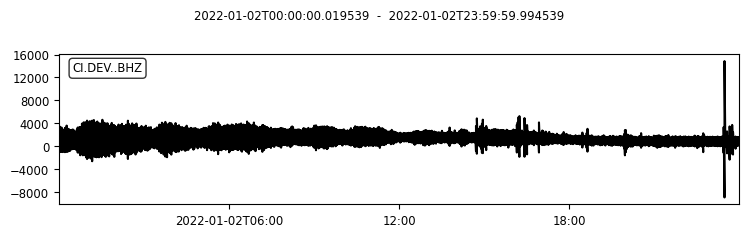

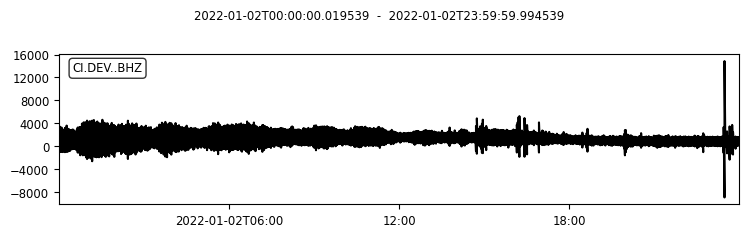

In [10]:
d.stream.plot()